In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
fs = 30720000

T = 1
x = np.fromfile('record_2022-04-09T11:09:29.569565', 'int16', count=int(T*fs*2))

# Scale amplitude ...
x = (x[::2] + 1j*x[1::2])/2e6

delta_f = -1300
samp_rate_error = 1 - 1.5e-6

x *= np.exp(1j*(2*np.pi*delta_f/fs*np.arange(x.size)))

In [3]:
# The units here are samples
Tu = 2048 # useful time of a symbol
cp_len = 144  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 160  # 5.2 usecs, used in symbol 0 in a slot

In [4]:
def zadoff_chu(u):
    n = np.arange(63)
    x = np.exp(-1j*np.pi*u*n*(n+1)/63)
    x[31] = 0  # This corresponds to the DC subcarrier
    return x

In [5]:
subcarriers_ss = slice(Tu//2 - 3*12 + 5, Tu//2 + 3*12 - 5 + 1)

In [6]:
zc_u = [25, 29, 34]
zc_time = np.empty((3, Tu), 'complex')
for j in range(3):
    zc = zadoff_chu(zc_u[j])
    zc_all = np.zeros(Tu, 'complex')
    zc_all[subcarriers_ss] = zc
    zc_time[j] = np.fft.ifft(np.fft.fftshift(zc_all))

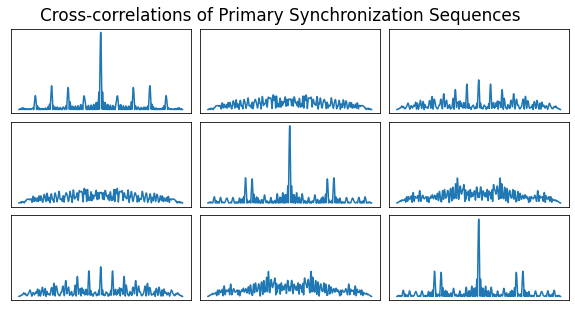

In [7]:
fig, axs = plt.subplots(3, 3, facecolor='w', sharex=True, sharey=True)
for j in range(3):
    for k in range(3):
        axs[j, k].plot(np.abs(np.correlate(zc_time[j], zc_time[k], mode='full')))
        axs[j, k].set_xticks([])
        axs[j, k].set_yticks([])
plt.suptitle('Cross-correlations of Primary Synchronization Sequences', y=0.94)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

In [8]:
zc_corr = np.empty((3, int(5e-3 * fs)), 'complex')
for j in range(zc_corr.shape[1]):
    zc_corr[:, j] = np.sum(x[j:][:Tu] * np.conjugate(zc_time), axis=1)
t_corr = np.arange(zc_corr.shape[1])/fs

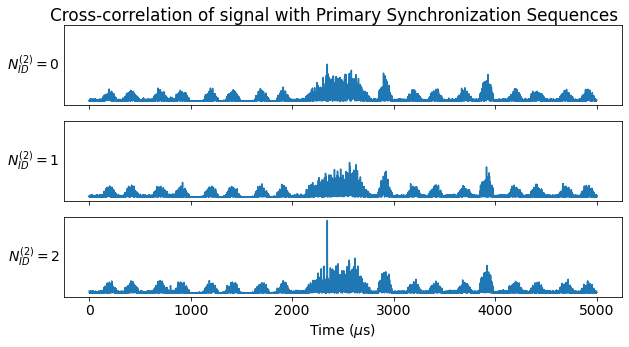

In [9]:
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for j, ax in enumerate(axs.ravel()):
    ax.plot(t_corr*1e6, np.abs(zc_corr[j]))
    ax.set_yticks([])
    ax.set_ylabel(f'$N_{{ID}}^{{(2)}} = {j}$', rotation=0,
                  horizontalalignment='right', verticalalignment='center')
axs[-1].set_xlabel('Time ($\mu$s)')
plt.suptitle('Cross-correlation of signal with Primary Synchronization Sequences', y=0.93);

In [10]:
nid2, a0 = np.unravel_index(np.argmax(np.abs(zc_corr)), zc_corr.shape)
a0
nid2, a0

(2, 72056)

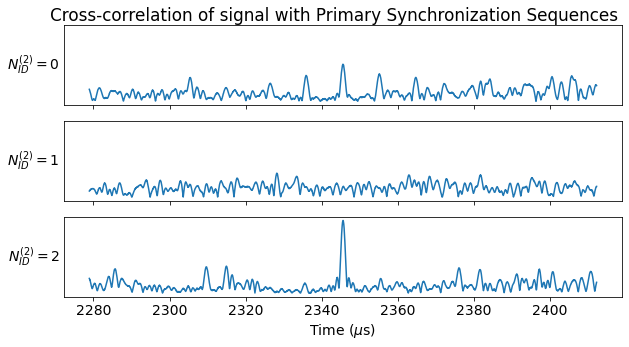

In [11]:
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for j, ax in enumerate(axs.ravel()):
    sel = slice(a0-Tu, a0+Tu)
    ax.plot(t_corr[sel]*1e6, np.abs(zc_corr[j, sel]))
    ax.set_yticks([])
    ax.set_ylabel(f'$N_{{ID}}^{{(2)}} = {j}$', rotation=0,
                  horizontalalignment='right', verticalalignment='center')
axs[-1].set_xlabel('Time ($\mu$s)')
plt.suptitle('Cross-correlation of signal with Primary Synchronization Sequences', y=0.93);

In [12]:
n_half_frames = x[a0:].size // int(fs * 5e-3)
syms_pss = np.empty((n_half_frames, 62), 'complex')
syms_pss_wipe = np.empty_like(syms_pss)
no_dc = np.concatenate((np.arange(31), np.arange(32, 63)))
for j in range(n_half_frames):
    syms = np.fft.fftshift(np.fft.fft(x[a0 + round(5e-3 * fs * j * samp_rate_error):][:Tu]))
    syms_pss[j] = syms[subcarriers_ss][no_dc]
    syms_pss_wipe[j] = syms_pss[j] * np.conjugate(zadoff_chu(zc_u[nid2])[no_dc])

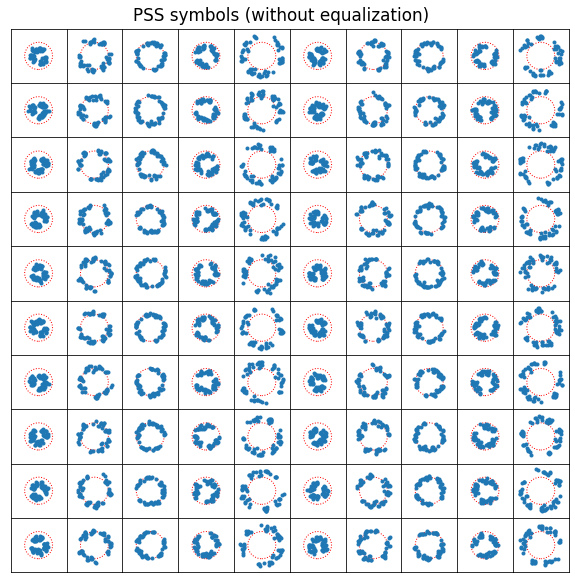

In [13]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols (without equalization)', y=0.91);

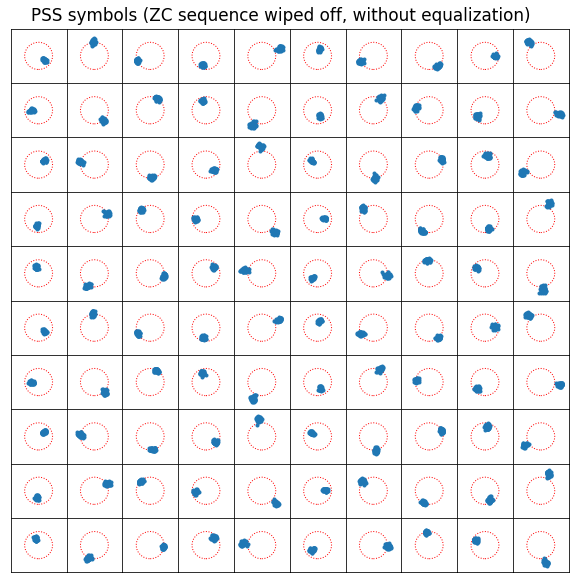

In [14]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss_wipe[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols (ZC sequence wiped off, without equalization)', y=0.91);

In [15]:
p_abs = np.empty((n_half_frames, 1))
p_angle = np.empty((n_half_frames, 2))
h_pss = np.empty((n_half_frames, 62), 'complex')

for j in range(n_half_frames):
    p_abs[j] = np.polyfit(no_dc, np.abs(syms_pss_wipe[j]), p_abs.shape[1] - 1)
    h_abs = np.polyval(p_abs[j], no_dc)
    avg_angle = np.angle(np.average(syms_pss_wipe[j]))
    p_angle[j] = np.polyfit(no_dc, np.angle(syms_pss_wipe[j] * np.exp(-1j*avg_angle)), p_angle.shape[1] - 1)
    p_angle[j, 1] += avg_angle
    h_angle = np.exp(1j * (np.polyval(p_angle[j], no_dc)))
    h_pss[j] = h_abs * h_angle

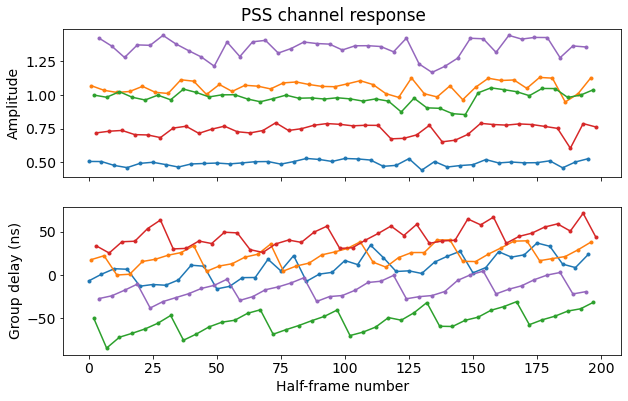

In [16]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
for j in range(5):
    n = np.arange(p_angle.shape[0])[j::5]
    axs[0].plot(n, p_abs[j::5, 0], '.-')
    axs[1].plot(n, p_angle[j::5, 0]/(2*np.pi)/15e3*1e9, '.-')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Group delay (ns)')
axs[1].set_xlabel('Half-frame number')
plt.suptitle('PSS channel response', y=0.93);

In [17]:
syms_pss_wipe_eq = syms_pss_wipe / h_pss

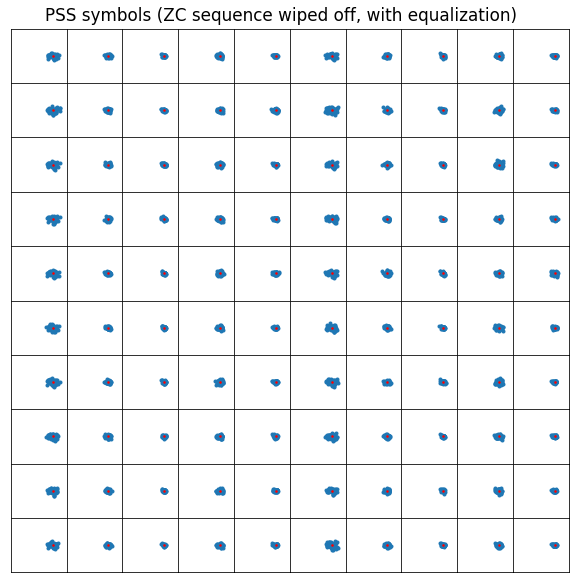

In [18]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss_wipe_eq[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.plot([1], [0], '.', color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols (ZC sequence wiped off, with equalization)', y=0.91);

In [19]:
syms_pss_wipe_eq_templates = np.array([np.average(syms_pss_wipe_eq[j::5], axis=0)
                                       for j in range(5)])

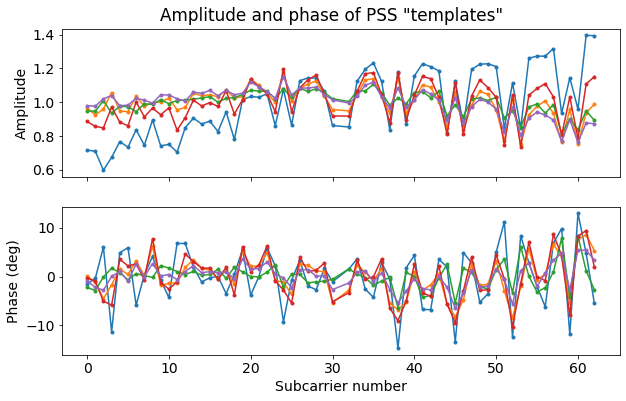

In [20]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(syms_pss_wipe_eq_templates.T), '.-')
axs[0].set_ylabel('Amplitude')
axs[1].plot(no_dc, np.rad2deg(np.angle(syms_pss_wipe_eq_templates.T)), '.-')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Amplitude and phase of PSS "templates"', y=0.93);

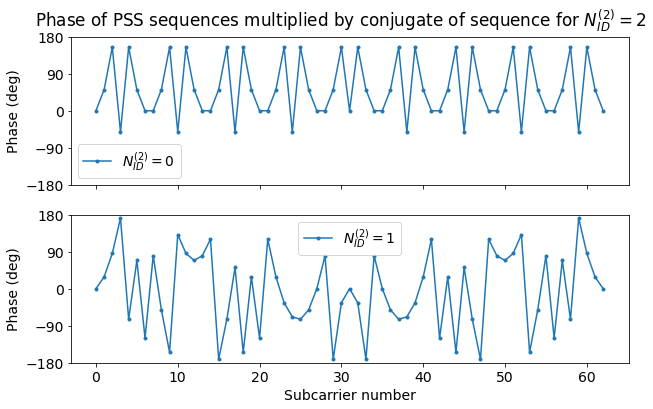

In [21]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
for j in range(2):
    w = zadoff_chu(zc_u[j]) * np.conjugate(zadoff_chu(zc_u[2]))
    axs[j].plot(np.rad2deg(np.angle(w)), '.-', label=f'$N_{{ID}}^{{(2)}}={j}$')
    axs[j].set_ylim((-180, 180))
    axs[j].set_yticks(np.arange(-180, 180+90, 90))
    axs[j].set_ylabel('Phase (deg)')
    axs[j].legend()
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Phase of PSS sequences multiplied by conjugate of sequence for $N_{{ID}}^{{(2)}}=2$', y=0.95);

In [22]:
p_fine_abs = np.empty((5, 4))
p_fine_angle = np.empty((5, 4))
h_fine_pss = np.empty((5, 62), 'complex')

for j in range(5):
    y = syms_pss_wipe_eq_templates[j]
    p_fine_abs[j] = np.polyfit(no_dc, np.abs(y), p_fine_abs.shape[1] - 1)
    h_abs = np.polyval(p_fine_abs[j], no_dc)
    p_fine_angle[j] = np.polyfit(no_dc, np.angle(y), p_fine_angle.shape[1] - 1)
    h_angle = np.exp(1j * (np.polyval(p_fine_angle[j], no_dc)))
    h_fine_pss[j] = h_abs * h_angle

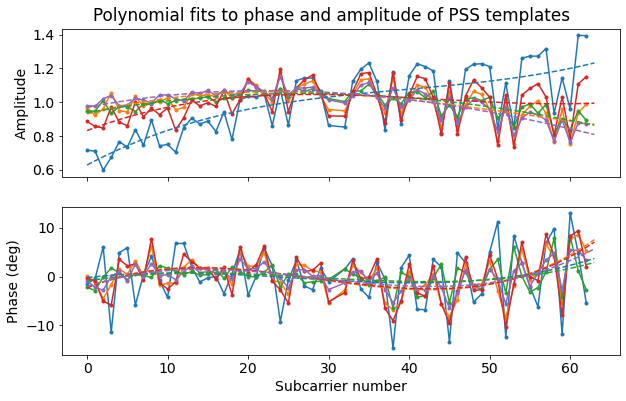

In [23]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(syms_pss_wipe_eq_templates.T), '.-');
t = np.linspace(0, 63, 100)
axs[0].set_prop_cycle(None)
for j in range(5):
    axs[0].plot(t, np.polyval(p_fine_abs[j], t), '--')
axs[1].plot(no_dc, np.rad2deg(np.angle(syms_pss_wipe_eq_templates.T)), '.-');
axs[1].set_prop_cycle(None)
for j in range(5):
    axs[1].plot(t, np.rad2deg(np.polyval(p_fine_angle[j], t)), '--')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Polynomial fits to phase and amplitude of PSS templates', y=0.93);

In [24]:
pss_res1 = syms_pss_wipe_eq_templates - h_fine_pss

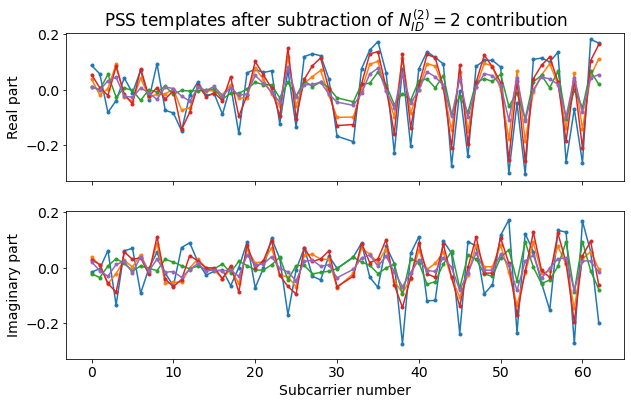

In [25]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True, sharey=True)
axs[0].plot(no_dc, pss_res1.real.T, '.-')
axs[0].set_ylabel('Real part')
axs[1].plot(no_dc, pss_res1.imag.T, '.-')
axs[1].set_ylabel('Imaginary part')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('PSS templates after subtraction of $N_{{ID}}^{{(2)}}=2$ contribution', y=0.94);

In [26]:
damp0s = np.linspace(-0.2, 0.2, 100)
damp1s = np.linspace(-0.2, 0.2, 100)
residuals = np.empty((damp0s.size, damp1s.size, 5))
for j, damp0 in enumerate(damp0s):
    for k, damp1 in enumerate(damp1s):
        amp0 = 1 + damp0 * (no_dc - np.average(no_dc))
        amp1 = 1 + damp1 * (no_dc - np.average(no_dc))
        A = np.stack([amp0 * (zadoff_chu(zc_u[0]) * np.conjugate(zadoff_chu(zc_u[nid2])))[no_dc],
                      amp1 * (zadoff_chu(zc_u[1]) * np.conjugate(zadoff_chu(zc_u[nid2])))[no_dc]])
        solve = np.linalg.lstsq(A.T, pss_res1.T, rcond=None)
        residuals[j, k, :] = solve[1]

Text(0.5, 0.7, 'Residuals of linear least squares by amplitude vs. frequency for $N_{{ID}}^{{(2)}}=0, 1$')

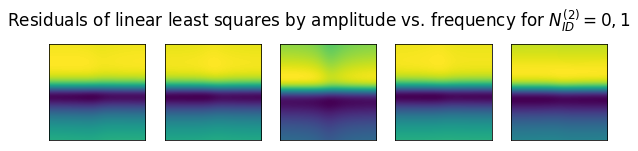

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(10, 6), facecolor='w', sharex=True)
for j in range(5):
    axs[j].imshow(residuals[..., j])
    axs[j].set_xticks([])
    axs[j].set_yticks([])
plt.suptitle('Residuals of linear least squares by amplitude vs. frequency for $N_{{ID}}^{{(2)}}=0, 1$', y=0.7)

In [28]:
unrv = np.unravel_index(np.argmin(residuals.reshape((-1, 5)), axis=0),
                        residuals.shape[:2])
damp0s[unrv[0]]

array([0.02222222, 0.02626263, 0.04646465, 0.02222222, 0.03434343])

In [29]:
damp1 = 0
solves = []
residuals = []
for j, damp0 in enumerate(damp0s[unrv[0]]):
    amp0 = 1 + damp0 * (no_dc - np.average(no_dc))
    amp1 = 1 + damp1 * (no_dc - np.average(no_dc))
    A = np.stack([amp0 * (zadoff_chu(zc_u[0]) * np.conjugate(zadoff_chu(zc_u[nid2])))[no_dc],
                  amp1 * (zadoff_chu(zc_u[1]) * np.conjugate(zadoff_chu(zc_u[nid2])))[no_dc]])
    solves.append(np.linalg.lstsq(A.T, pss_res1[j], rcond=None))
    residuals.append(pss_res1[j] - A.T @ solves[-1][0])
sols = np.array([s[0] for s in solves])
residuals = np.array(residuals)

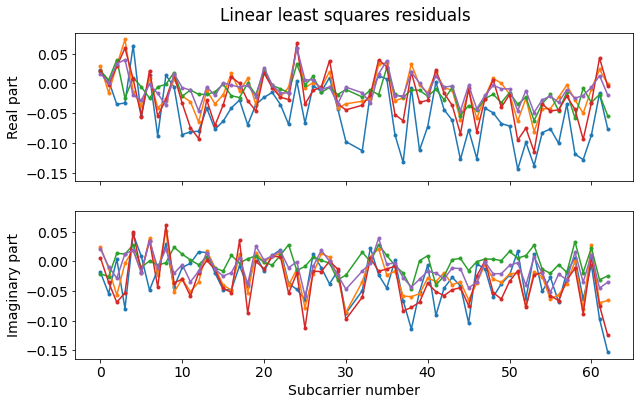

In [30]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True, sharey=True)
axs[0].plot(no_dc, residuals.real.T, '.-')
axs[0].set_ylabel('Real part')
axs[1].plot(no_dc, residuals.imag.T, '.-')
axs[1].set_ylabel('Imaginary part')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Linear least squares residuals', y=0.94);

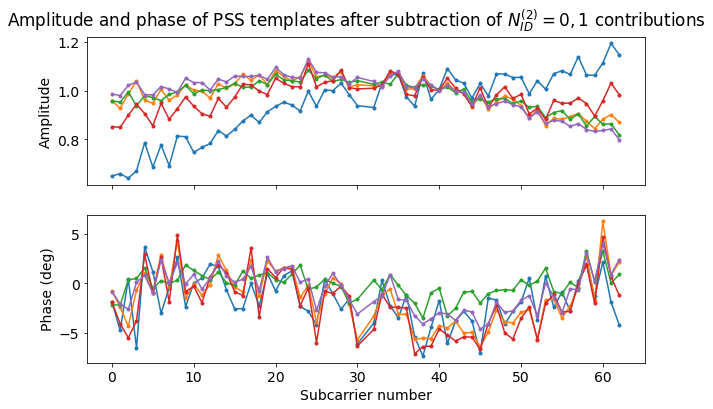

In [31]:
subtract_smalls = syms_pss_wipe_eq_templates - pss_res1 + residuals
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(subtract_smalls.T), '.-')
axs[0].set_ylabel('Amplitude')
axs[1].plot(no_dc, np.rad2deg(np.angle(subtract_smalls.T)), '.-')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Amplitude and phase of PSS templates after subtraction of $N_{{ID}}^{{(2)}}=0, 1$ contributions',
             y=0.95);

In [32]:
p_fine2_abs = np.empty((5, 4))
p_fine2_angle = np.empty((5, 4))
h_fine2_pss = np.empty((5, 62), 'complex')

for j in range(5):
    y = subtract_smalls[j]
    p_fine2_abs[j] = np.polyfit(no_dc, np.abs(y), p_fine2_abs.shape[1] - 1)
    h_abs = np.polyval(p_fine2_abs[j], no_dc)
    p_fine2_angle[j] = np.polyfit(no_dc, np.angle(y), p_fine2_angle.shape[1] - 1)
    h_angle = np.exp(1j * (np.polyval(p_fine2_angle[j], no_dc)))
    h_fine2_pss[j] = h_abs * h_angle

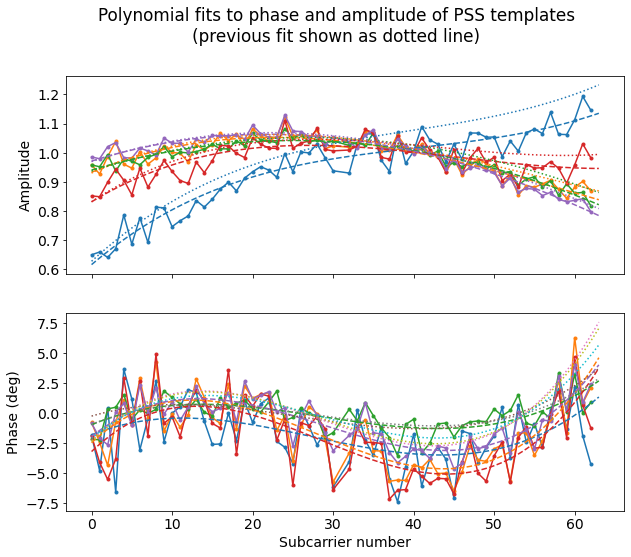

In [33]:
fig, axs = plt.subplots(2, figsize=(10, 8), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(subtract_smalls.T), '.-');
t = np.linspace(0, 63, 100)
axs[0].set_prop_cycle(None)
for j in range(5):
    axs[0].plot(t, np.polyval(p_fine2_abs[j], t), '--')
axs[0].set_prop_cycle(None)
for j in range(5):
    axs[0].plot(t, np.polyval(p_fine_abs[j], t), ':')
axs[1].plot(no_dc, np.rad2deg(np.angle(subtract_smalls.T)), '.-');
axs[1].set_prop_cycle(None)
for j in range(5):
    axs[1].plot(t, np.rad2deg(np.polyval(p_fine2_angle[j], t)), '--')
for j in range(5):
    axs[1].plot(t, np.rad2deg(np.polyval(p_fine_angle[j], t)), ':')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Polynomial fits to phase and amplitude of PSS templates\n(previous fit shown as dotted line)',
             y=1);

In [34]:
damp1 = 0
solves = []
residuals = []
for j, damp0 in enumerate(damp0s[unrv[0]]):
    amp0 = 1 + damp0 * (no_dc - np.average(no_dc))
    amp1 = 1 + damp1 * (no_dc - np.average(no_dc))
    A = np.stack([h_fine2_pss[j],
                  amp0 * (zadoff_chu(zc_u[0]) * np.conjugate(zadoff_chu(zc_u[nid2])))[no_dc],
                  amp1 * (zadoff_chu(zc_u[1]) * np.conjugate(zadoff_chu(zc_u[nid2])))[no_dc]])
    solves.append(np.linalg.lstsq(A.T, syms_pss_wipe_eq_templates[j], rcond=None))
    residuals.append(syms_pss_wipe_eq_templates[j] - A.T @ solves[-1][0])
sols = np.array([s[0] for s in solves])
residuals = np.array(residuals)

In [35]:
sols

array([[ 9.87792771e-01-0.00717075j,  1.58113060e-01-0.04352725j,
         3.57159560e-02+0.01593894j],
       [ 9.97404817e-01-0.00480305j,  7.61761907e-02+0.03200351j,
        -6.91610642e-04+0.01293967j],
       [ 9.97210690e-01-0.00049753j,  3.39509781e-02-0.02234319j,
         5.40801780e-03-0.00965376j],
       [ 9.94913786e-01-0.00694785j,  1.15882101e-01+0.0304707j ,
         8.91407207e-03+0.01979381j],
       [ 9.98254575e-01-0.00230072j,  4.37640219e-02+0.0102495j ,
        -1.53471592e-03+0.0015331j ]])

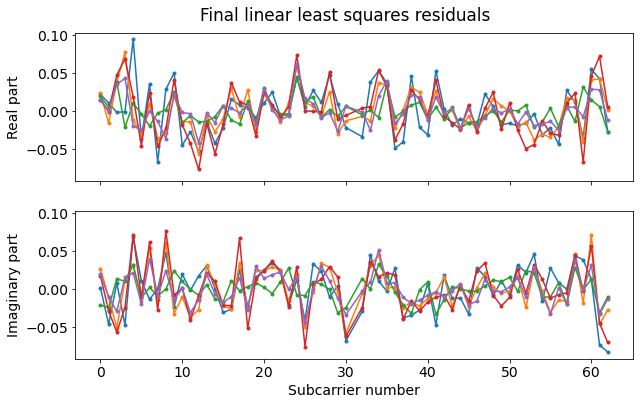

In [36]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True, sharey=True)
axs[0].plot(no_dc, residuals.real.T, '.-')
axs[0].set_ylabel('Real part')
axs[1].plot(no_dc, residuals.imag.T, '.-')
axs[1].set_ylabel('Imaginary part')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Final linear least squares residuals', y=0.94);

In [37]:
h_pss_abs_templates = np.array([np.average(np.abs(h_pss[j::5])) for j in range(5)])
h_pss_abs_templates

array([0.49717347, 1.05809103, 0.98048506, 0.7404428 , 1.34878549])

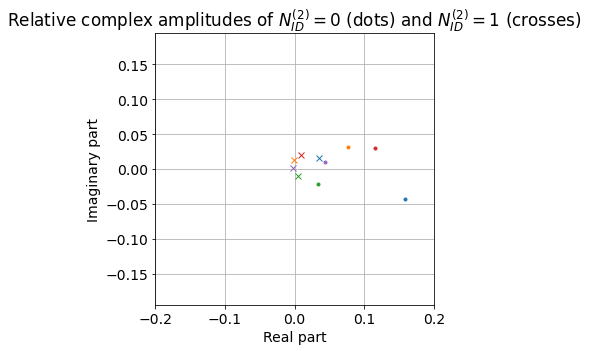

In [38]:
plt.figure(figsize=(5, 5))
for j in range(5):
    plt.plot(sols[j, 1].T.real, sols[j, 1].T.imag, '.')
plt.gca().set_prop_cycle(None)
for j in range(5):
    plt.plot(sols[j, 2].T.real, sols[j, 2].T.imag, 'x')
plt.axis('equal')
L = 0.2
plt.xlim((-L, L))
plt.ylim((-L, L))
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Relative complex amplitudes of $N_{{ID}}^{{(2)}}=0$ (dots) and $N_{{ID}}^{{(2)}}=1$ (crosses)');

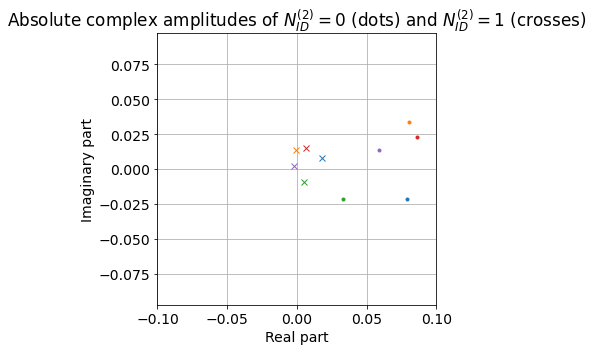

In [39]:
plt.figure(figsize=(5, 5))
for j in range(5):
    plt.plot(h_pss_abs_templates[j] * sols[j, 1].T.real, h_pss_abs_templates[j] * sols[j, 1].T.imag, '.')
plt.gca().set_prop_cycle(None)
for j in range(5):
    plt.plot(h_pss_abs_templates[j] * sols[j, 2].T.real, h_pss_abs_templates[j] * sols[j, 2].T.imag, 'x')
plt.axis('equal')
L = 0.1
plt.xlim((-L, L))
plt.ylim((-L, L))
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Absolute complex amplitudes of $N_{{ID}}^{{(2)}}=0$ (dots) and $N_{{ID}}^{{(2)}}=1$ (crosses)');

In [40]:
# Secondary Synchronization Signal
syms_sss = np.empty_like(syms_pss)
syms_sss_eq = np.empty_like(syms_pss)
for j in range(n_half_frames):
    syms = np.fft.fftshift(np.fft.fft(x[a0 + int(5e-3 * fs * j * samp_rate_error) - Tu - cp_len:][:Tu]))
    syms_sss[j] = syms[subcarriers_ss][no_dc]
    syms_sss_eq[j] = syms_sss[j] / (h_pss[j] * h_fine2_pss[j % 5])

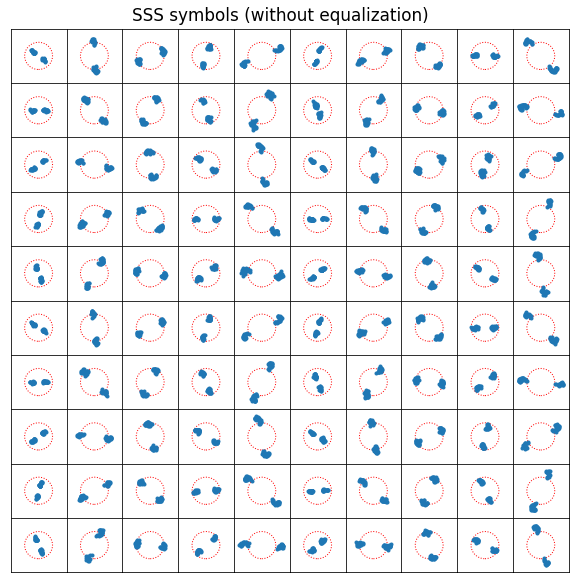

In [41]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols (without equalization)', y=0.91);

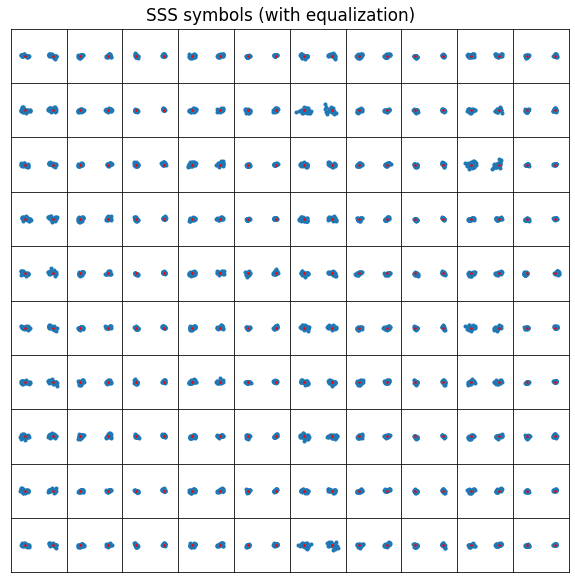

In [42]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss_eq[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.plot([1, -1], [0, 0], '.', color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols (with equalization)', y=0.91);

In [43]:
mseq_s = np.empty(31, 'int8')
mseq_s[:5] = [0, 0, 0, 0, 1]
for j in range(26):
    mseq_s[j + 5] = mseq_s[j + 2] ^ mseq_s[j]
mseq_s = 1 - 2*mseq_s

mseq_c = np.empty(31, 'int8')
mseq_c[:5] = [0, 0, 0, 0, 1]
for j in range(26):
    mseq_c[j + 5] = mseq_c[j + 3] ^ mseq_c[j]
mseq_c = 1 - 2*mseq_c

mseq_z = np.empty(31, 'int8')
mseq_z[:5] = [0, 0, 0, 0, 1]
for j in range(26):
    mseq_z[j + 5] = mseq_z[j + 4] ^ mseq_z[j + 2] ^ mseq_z[j + 1] ^ mseq_z[j]
mseq_z = 1 - 2*mseq_z

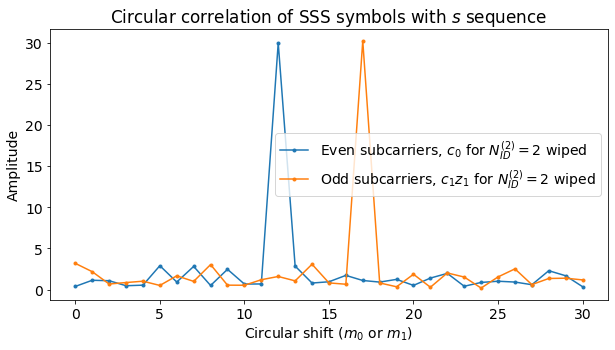

In [44]:
syms_sss_deinter = syms_sss_eq[0].reshape(-1, 2).T
c0 = np.roll(mseq_c, -nid2)
c1 = np.roll(mseq_c, -nid2-3)
corr_mseq_s = np.fft.ifft(np.conjugate(np.fft.fft(syms_sss_deinter[0] * c0)) * np.fft.fft(mseq_s))
m0_or_m1 = np.argmax(np.abs(corr_mseq_s))
plt.plot(np.abs(corr_mseq_s), '.-', label='Even subcarriers, $c_0$ for $N_{{ID}}^{{(2)}}=2$ wiped')

z1 = np.roll(mseq_z, -(m0_or_m1 % 8))
corr_mseq_s_2 = np.fft.ifft(np.conjugate(np.fft.fft(syms_sss_deinter[1] * c1 * z1))
                            * np.fft.fft(mseq_s))
m1_or_m0 = np.argmax(np.abs(corr_mseq_s_2))
plt.plot(np.abs(corr_mseq_s_2), '.-', label='Odd subcarriers, $c_1z_1$ for $N_{{ID}}^{{(2)}}=2$ wiped')
plt.xlabel('Circular shift ($m_0$ or $m_1$)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Circular correlation of SSS symbols with $s$ sequence');

In [45]:
m0_or_m1, m1_or_m0

(12, 17)

In [46]:
nid1s = np.arange(168)
qprime = np.int32(nid1s / 30)
q = np.int32((nid1s + qprime*(qprime + 1)/2)/30)
mprime = nid1s + q*(q + 1)//2
m0_vs_nid1 = mprime % 31
m1_vs_nid1 = (m0_vs_nid1 + mprime // 31 + 1) % 31
m0m1_vs_nid1 = np.stack([m0_vs_nid1, m1_vs_nid1]).T

In [47]:
np.where(np.all(m0m1_vs_nid1 == [m0_or_m1, m1_or_m0], axis = 1))[0]  # for subframe 0

array([126])

In [48]:
np.where(np.all(m0m1_vs_nid1 == [m1_or_m0, m0_or_m1], axis = 1))[0]  # for subframe 5

array([], dtype=int64)

In [49]:
nid1 = 126
subframe = 0

In [50]:
pci = 3 * nid1 + nid2
pci

380

In [51]:
def sss_seq(pci, even=True):
    nid1 = pci // 3
    nid2 = pci % 3
    c0 = np.roll(mseq_c, -nid2)
    c1 = np.roll(mseq_c, -nid2-3)
    m0 = m0_vs_nid1[nid1]
    m1 = m1_vs_nid1[nid1]
    m0_or_m1 = m0 if even else m1
    m1_or_m0 = m1 if even else m0
    z1 = np.roll(mseq_z, -(m0_or_m1 % 8))
    sss = np.empty(62, 'int8')
    sss[::2] = np.roll(mseq_s, -m0_or_m1) * c0
    sss[1::2] = np.roll(mseq_s, -m1_or_m0) * c1 * z1
    return sss

In [52]:
syms_sss_wipe = syms_sss_eq.copy()
syms_sss_wipe[::2] *= sss_seq(pci, even=True)
syms_sss_wipe[1::2] *= sss_seq(pci, even=False)

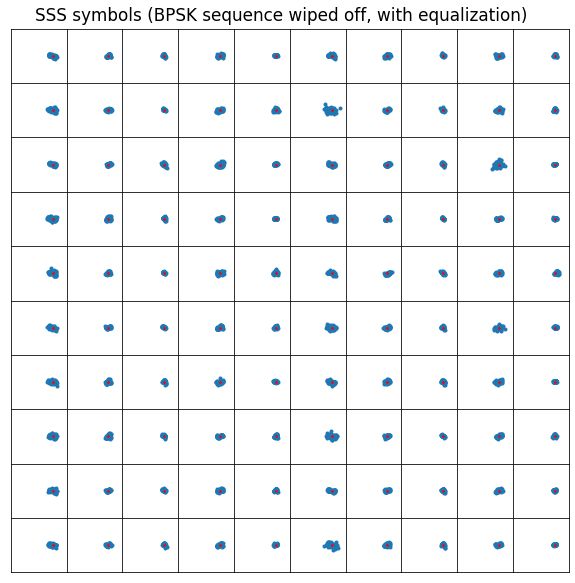

In [53]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss_wipe[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.plot([1], [0], '.', color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols (BPSK sequence wiped off, with equalization)', y=0.91);

In [54]:
syms_sss_wipe_templates = np.array([np.average(syms_sss_wipe[j::5], axis=0)
                                    for j in range(5)])

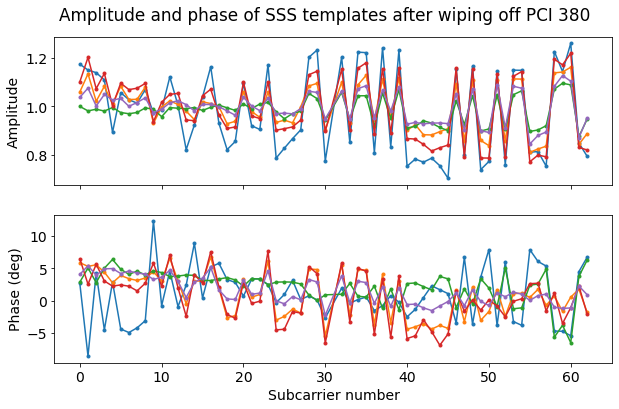

In [55]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(syms_sss_wipe_templates.T), '.-')
axs[0].set_ylabel('Amplitude')
axs[1].plot(no_dc, np.rad2deg(np.angle(syms_sss_wipe_templates.T)), '.-')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Amplitude and phase of SSS templates after wiping off PCI 380',
             y=0.95);

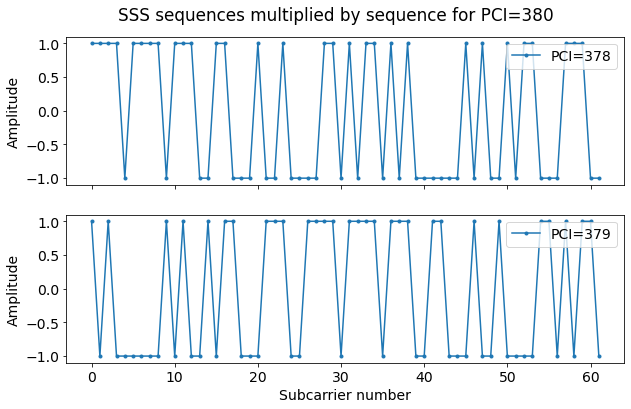

In [56]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
for j in range(2):
    w = sss_seq(378 + j) * sss_seq(380)
    axs[j].plot(w, '.-', label=f'PCI={378+j}')
    axs[j].set_ylabel('Amplitude')
    axs[j].legend()
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('SSS sequences multiplied by sequence for PCI=380', y=0.95);

In [57]:
residual_1 = syms_sss_eq.copy()
residual_1[::2] -= sss_seq(pci, even=True)
residual_1[1::2] -= sss_seq(pci, even=False)

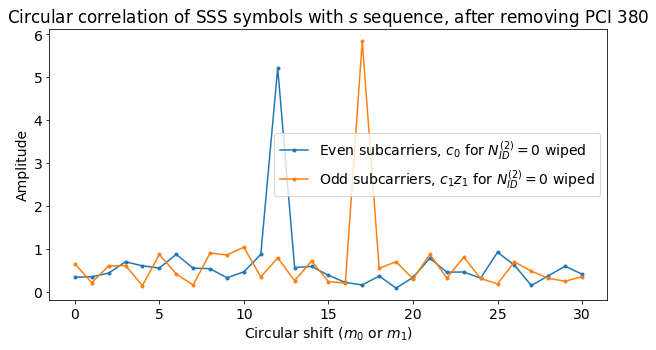

In [58]:
syms_sss_deinter = residual_1[0].reshape(-1, 2).T
nid2_1 = 0
c0_1 = np.roll(mseq_c, -nid2_1)
c1_1 = np.roll(mseq_c, -nid2_1-3)
corr_mseq_s = np.fft.ifft(np.conjugate(np.fft.fft(syms_sss_deinter[0] * c0_1)) * np.fft.fft(mseq_s))
plt.plot(np.abs(corr_mseq_s), '.-', label='Even subcarriers, $c_0$ for $N_{{ID}}^{{(2)}}=0$ wiped')
corr_mseq_s_2 = np.fft.ifft(np.conjugate(np.fft.fft(syms_sss_deinter[1] * c1_1 * z1))
                            * np.fft.fft(mseq_s))
m1_or_m0 = np.argmax(np.abs(corr_mseq_s_2))
plt.plot(np.abs(corr_mseq_s_2), '.-', label='Odd subcarriers, $c_1z_1$ for $N_{{ID}}^{{(2)}}=0$ wiped')
plt.xlabel('Circular shift ($m_0$ or $m_1$)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Circular correlation of SSS symbols with $s$ sequence, after removing PCI 380');

In [59]:
residual_1_wipe = residual_1.copy()
residual_1_wipe[::2] *= sss_seq(378, even=True)
residual_1_wipe[1::2] *= sss_seq(378, even=False)

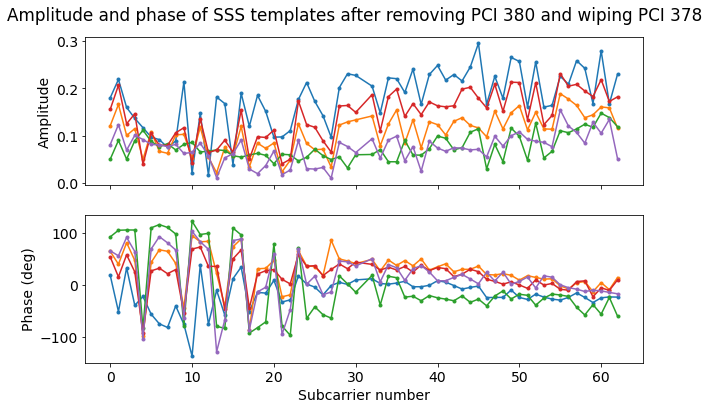

In [60]:
residual_1_wipe_templates = np.array([np.average(residual_1_wipe[j::5], axis=0)
                                      for j in range(5)])
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(residual_1_wipe_templates.T), '.-')
axs[0].set_ylabel('Amplitude')
axs[1].plot(no_dc, np.rad2deg(np.angle(residual_1_wipe_templates.T)), '.-')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Amplitude and phase of SSS templates after removing PCI 380 and wiping PCI 378',
             y=0.95);

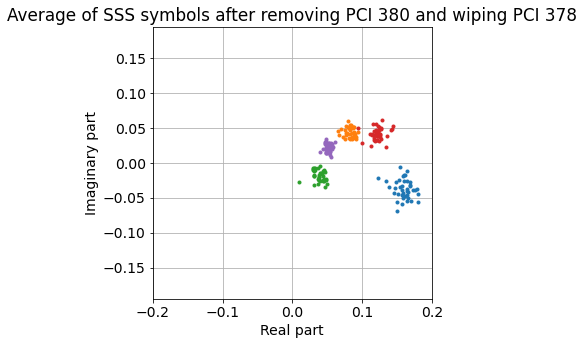

In [61]:
plt.figure(figsize=(5, 5))
residual_1_avg = np.average(residual_1_wipe, axis=1)
for j in range(5):
    plt.plot(residual_1_avg[j::5].real, residual_1_avg[j::5].imag, '.')
plt.axis('equal')
plt.xlim((-0.2, 0.2))
plt.ylim((-0.2, 0.2))
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Average of SSS symbols after removing PCI 380 and wiping PCI 378');

In [62]:
residual_2 = residual_1 * (1 - residual_1_avg[:, np.newaxis] / residual_1_wipe)

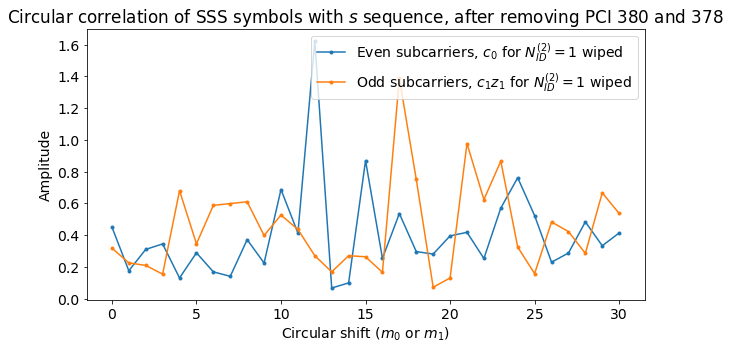

In [63]:
syms_sss_deinter = residual_2[0].reshape(-1, 2).T
nid2_2 = 1
c0_2 = np.roll(mseq_c, -nid2_2)
c1_2 = np.roll(mseq_c, -nid2_2-3)
corr_mseq_s = np.fft.ifft(np.conjugate(np.fft.fft(syms_sss_deinter[0] * c0_2)) * np.fft.fft(mseq_s))
plt.plot(np.abs(corr_mseq_s), '.-', label='Even subcarriers, $c_0$ for $N_{{ID}}^{{(2)}}=1$ wiped')
corr_mseq_s_2 = np.fft.ifft(np.conjugate(np.fft.fft(syms_sss_deinter[1] * c1_2 * z1))
                            * np.fft.fft(mseq_s))
m1_or_m0 = np.argmax(np.abs(corr_mseq_s_2))
plt.plot(np.abs(corr_mseq_s_2), '.-', label='Odd subcarriers, $c_1z_1$ for $N_{{ID}}^{{(2)}}=1$ wiped')
plt.xlabel('Circular shift ($m_0$ or $m_1$)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Circular correlation of SSS symbols with $s$ sequence, after removing PCI 380 and 378');

In [64]:
syms_sss_templates = syms_sss / h_pss
syms_sss_templates[::2] *= sss_seq(380, even=True)
syms_sss_templates[1::2] *= sss_seq(380, even=False)
syms_sss_templates = np.array([np.average(syms_sss_templates[j::5], axis=0)
                               for j in range(5)])

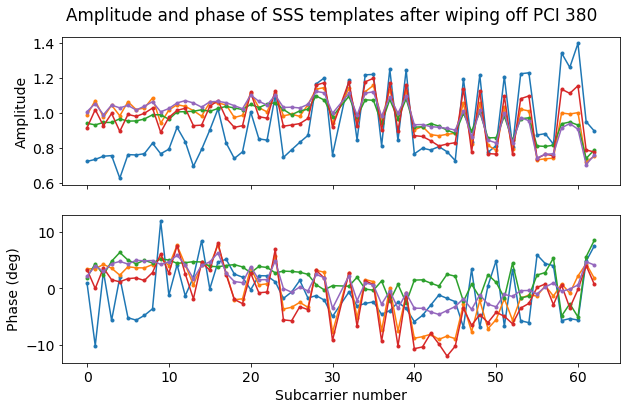

In [65]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(syms_sss_templates.T), '.-')
axs[0].set_ylabel('Amplitude')
axs[1].plot(no_dc, np.rad2deg(np.angle(syms_sss_templates.T)), '.-')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Amplitude and phase of SSS templates after wiping off PCI 380',
             y=0.95);

In [66]:
damp1 = 0
solves = []
residuals = []
residuals_378 = []
for j, damp0 in enumerate(damp0s[unrv[0]]):
    amp0 = 1 + damp0 * (no_dc - np.average(no_dc))
    amp1 = 1 + damp1 * (no_dc - np.average(no_dc))
    A = np.stack([h_fine2_pss[j],
                  amp0 * sss_seq(378) * sss_seq(380),
                  amp1 * sss_seq(379) * sss_seq(380)])
    solves.append(np.linalg.lstsq(A.T, syms_sss_templates[j], rcond=None))
    residuals.append(syms_sss_templates[j] - A.T @ solves[-1][0])
    s = solves[-1][0].copy()
    s[1] = 0
    residuals_378.append(syms_sss_templates[j] - A.T @ s)
sols = np.array([s[0] for s in solves])
residuals = np.array(residuals)
residuals_378 = np.array(residuals_378) * sss_seq(378) * sss_seq(380)

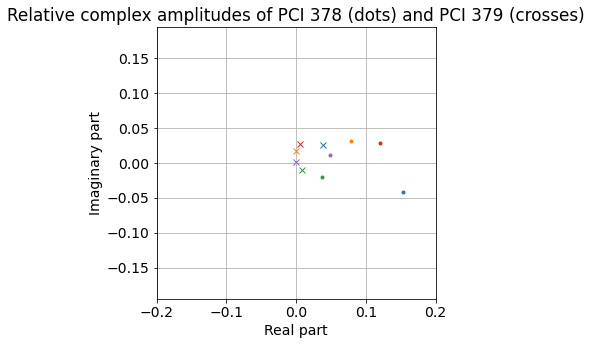

In [67]:
plt.figure(figsize=(5, 5))
for j in range(5):
    plt.plot(sols[j, 1].T.real, sols[j, 1].T.imag, '.')
plt.gca().set_prop_cycle(None)
for j in range(5):
    plt.plot(sols[j, 2].T.real, sols[j, 2].T.imag, 'x')
plt.axis('equal')
L = 0.2
plt.xlim((-L, L))
plt.ylim((-L, L))
plt.grid()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Relative complex amplitudes of PCI 378 (dots) and PCI 379 (crosses)');

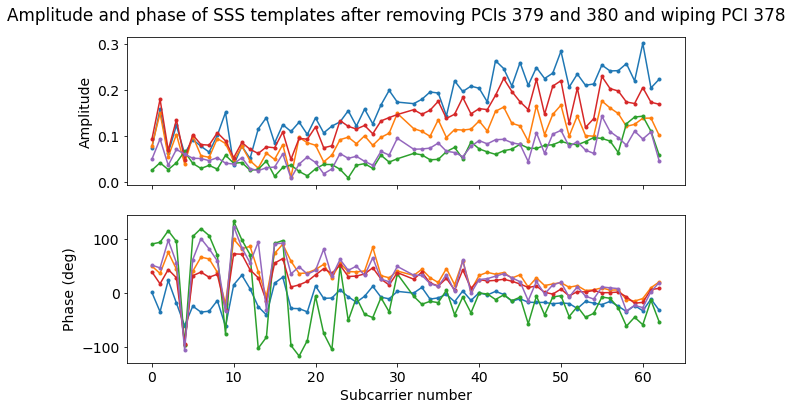

In [68]:
fig, axs = plt.subplots(2, figsize=(10, 6), facecolor='w', sharex=True)
axs[0].plot(no_dc, np.abs(residuals_378.T), '.-')
axs[0].set_ylabel('Amplitude')
axs[1].plot(no_dc, np.rad2deg(np.angle(residuals_378.T)), '.-')
axs[1].set_ylabel('Phase (deg)')
axs[1].set_xlabel('Subcarrier number')
plt.suptitle('Amplitude and phase of SSS templates after removing PCIs 379 and 380 and wiping PCI 378',
             y=0.95);

In [69]:
p_angle = np.empty((5, 2))
for j in range(5):
    n = np.arange(32)
    p_angle[j] = np.polyfit(n, np.angle(residuals_378[j, 30:]), 1)
delay_378_ns = p_angle[:, 0] / (2*np.pi) / 15e3 * 1e9
delay_378_ns

array([-178.62312763, -255.32855392, -237.99873772, -232.81694263,
       -273.68319556])